#### EVALUATION FILE

##### This file is to evaluate the loaded models with an specific validation keys

In [1]:
import torch
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.transforms.functional import crop
import gc
import random

from torch.utils.data import Dataset
from Utils.logger import initialize_logger, get_logger
from scipy import signal
from Utils.config import (
    IMG_PATH,
    PATH_DATASET,
    SERVER_SLP_DATASET_PATH,
    USE_PHYSICAL_DATA,
)

from Utils import (
    metrics,
)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(USE_PHYSICAL_DATA)

True


In [2]:
# List of the paths of the test arrays

import json

def read_json(f):
    data = json.load(f)
    if PATH_DATASET == 'Server':
        return data
    else:
        dic_paths = {}

        for key, paths in data.items():
            dic_paths[key] = []
            for i, path in enumerate(paths):
                parts = path.split("danaLab", 2) 
                result = "SLP".join(parts[1:]).lstrip('/')
                modified_path = os.path.join(LOCAL_SLP_DATASET_PATH, result)
                dic_paths[key].append(modified_path)

        print(dic_paths)
        
        return dic_paths


In [3]:
# Function to get all the files of an especific cover or an especific patient

covers = ['cover1','cover2','uncover']

def filter_files(dic,filter):
    if filter is not None:
        filter_dic = {}
        for key, paths in dic.items():
            filter_dic[key]=[]
            for path in paths:
                if filter in path:
                    filter_dic[key].append(path)
        return filter_dic
    else:
        return dic

In [4]:
# class CustomDataset

class CustomDataset(Dataset):
    # Dataset for the random option
    # Includes:
    # - IR arrays
    # - PR arrays
    # Physical data
    def __init__(self, ir_paths, pm_paths, p_data, transform=None):

        self.ir_paths = ir_paths
        self.pm_paths = pm_paths
        self.p_data = p_data

        self.transform = transform

    def __len__(self):
        return len(self.ir_paths)

    def __getitem__(self, index):

        input_path = self.ir_paths[index]
        output_path = self.pm_paths[index]

        input_array = self.load_array(input_path)
        output_array = self.load_array(output_path)
        input_array = input_array.astype(np.float32)
        output_array = output_array.astype(np.float32)

        if self.transform:
            input_array = self.transform['input'](input_array)

            if PATH_DATASET == 'Server':
                parts = str(output_path.split("/")[-4])
            else:
                parts = str(output_path.split("\\")[-4])
            number = int(parts)
            p_vector = self.p_data.iloc[number-1]
            weight = p_vector[1]
            tensor_data = torch.tensor(p_vector.values)

            # Applying median filter
            median_array = signal.medfilt2d(output_array)
            max_array = np.maximum(output_array, median_array)

            area_m = 1.03226 / 10000
            ideal_pressure = weight * 9.81 / (area_m * 1000)

            output_array = (max_array / np.sum(max_array)) * ideal_pressure
            output_array = self.transform['output'](output_array)

            if USE_PHYSICAL_DATA:
                return input_array, output_array, tensor_data
            else:
                return input_array, output_array

    def load_array(self, path):
        # Load the array
        array = np.load(path)
        return array


In [5]:
# Function to get the files that we want and do the transforms and create a dataloader to pass the model

def crop_array(array):
        return crop(array,7, 29, 140, 66)


def create_dataloader(dic,p_data,transform):

    list1 = dic['pm']
    list2 = dic['ir']
    
    # Pair the lists together
    paired_list = list(zip(list1, list2))
    
    # Shuffle the paired list
    random.shuffle(paired_list)
    
    # Unzip the shuffled paired list back into two lists
    shuffled_list1, shuffled_list2 = zip(*paired_list)
    
    # Update the dictionary with the shuffled lists
    dic['pm'] = list(shuffled_list1)
    dic['ir'] = list(shuffled_list2)

    
    dataset = CustomDataset(dic['ir'], dic['pm'], p_data, transform=transform)
    print('Len dataset:',len(dataset))

    test_loader = DataLoader(
            dataset, batch_size=1, shuffle=False, num_workers=0, drop_last=True)
    
    test_dataset_info = {
        'Number of samples': len(test_loader.dataset),
        'Batch size': test_loader.batch_size,
        'Number of batches': len(test_loader)
        }
    
    print(f"Val loader info: {test_dataset_info}")

    return test_loader


In [11]:
# Function to evaluate with a model loaded the files that we want with the metric

def evaluation(use_physical_data,model,model_file,metrics,test_loader,show_image,save):
    try:
        model.load_state_dict(torch.load(model_file, map_location=torch.device('cpu')))
        model.to(DEVICE)
    except Exception as e:
        raise RuntimeError(f"An error occurred while reading the file: {e}")
    else:
        print('Model Loaded')

    total_metric = [0, 0]

    model.eval()
    torch.cuda.empty_cache()  # Clean CUDA Cache if used GPU
    gc.collect()  # Collect trash to free memory not used

    with torch.no_grad():
        if not use_physical_data:

            for batch_idx, (input_images, target_images) in enumerate(test_loader, 1):
    
                input_img = input_images.to(DEVICE)
                target_img = target_images.to(DEVICE)
    
                output_img = model(input_img)
    
                for i, metric in enumerate(metrics):
    
                    test_metric = metric(output_img, target_img)
    
                    total_metric[i] += test_metric
    
                # Free memory in each iteration
                torch.cuda.empty_cache()  # Clean CUDA Cache if used GPU
                gc.collect()  # Collect trash to free memory not used

        else:
    
            for batch_idx, (input_images, target_images,tensor_data) in enumerate(test_loader, 1):
        
                input_img = input_images.to(DEVICE)
                target_img = target_images.to(DEVICE)
                tensor_data = tensor_data.to(DEVICE)
                
        
                output_img = model(input_img,tensor_data)
        
                for i, metric in enumerate(metrics):
        
                    test_metric = metric(output_img, target_img)
        
                    total_metric[i] += test_metric
        
                # Free memory in each iteration
                torch.cuda.empty_cache()  # Clean CUDA Cache if used GPU
                gc.collect()  # Collect trash to free memory not used

    print('Evaluation completed')
    epoch_metric = [(total_metric[0] /
                    len(test_loader)).item(), total_metric[1] / len(test_loader)]
    
    print(metrics)
    print(epoch_metric)
    
    m_str = [f"MSE - {epoch_metric[0]:.2f}", f"PerCS - {epoch_metric[1]:.2f}"]
    
    m_str = ", ".join(m_str)
    
    print(m_str)

    if show_image:

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
        axes[0].imshow(input_images.squeeze().cpu().numpy())
        axes[0].set_title('Input Image')
    
        axes[1].imshow(target_images.squeeze().cpu().numpy())
        axes[1].set_title('Target Image')
    
        axes[2].imshow(output_img.squeeze().cpu().numpy())
        axes[2].set_title('Output Image')
    
        fig.suptitle('Example of Input, Target and Output Image', fontsize=12)
        fig.text(0.5, 0.01, f': {m_str}', ha='center')
        if save:
            plt.savefig(os.path.join(IMG_PATH,'Comparing_output_model.png'))
        plt.show()

    return epoch_metric


In [12]:
from Models import (
    UNet,
    Simple_net,
    UNet_phy
)

# Variables
#MODEL_NAME = "UNet"
#name_model = "UNetNoPDataMSELoss_20240507020213.pth"
#test_json = "test_paths_20240506230502.json"

MODEL_NAME = "UNet_phy"
name_model = "UNetPDataMSE%PLoss_Type2_20240514153553.pth"
test_json = "test_paths_20240514131830.json"




# Models
models = {"Simple_net": Simple_net.Simple_net,
          "UNet": UNet.UNET, "UNet_phy": UNet_phy.UNET_phy}

# Metrics
m = [
    torch.nn.MSELoss(),
    metrics.PerCS()
]

# Create the model
if USE_PHYSICAL_DATA:
        model = models[MODEL_NAME](1, 9, 1).to(DEVICE)
else:
        model = models[MODEL_NAME](1, 1).to(DEVICE)

# Load the model
model_file = os.path.join(os.path.join((os.getcwd()),'Models/SavedModels'),name_model)

# Get the test paths
f = open(os.path.join(os.path.join((os.getcwd()),'Models/TestJson'),test_json))
dic_paths =read_json(f)

# Get the pdata
if PATH_DATASET == 'Server':
    path_arrays = SERVER_SLP_DATASET_PATH
else:
    path_arrays = LOCAL_SLP_DATASET_PATH

p_data = pd.read_csv(os.path.join(path_arrays, 'physiqueData.csv'))
p_data = p_data.drop('sub_idx', axis=1)
p_data = p_data.drop('gender', axis = 1)

# Data transformation if needed
transform = {
        'input': transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Lambda(crop_array),  
                    transforms.Resize((192, 84)),
		            transforms.Normalize(mean=[0.5], std=[0.5]),
                    ]),
        'output': transforms.Compose([transforms.ToTensor()])}



##### Execute this function to evaluate for each cover

--------------------------------------------------
EVALUATION FOR EACH COVER
--------------------------------------------------
Evaluation for cover: uncover
Len dataset: 306
Val loader info: {'Number of samples': 306, 'Batch size': 1, 'Number of batches': 306}
Model Loaded
Evaluation completed
[MSELoss(), PerCS()]
[1.5141533613204956, 0.9098770295155095]
MSE - 1.51, PerCS - 0.91


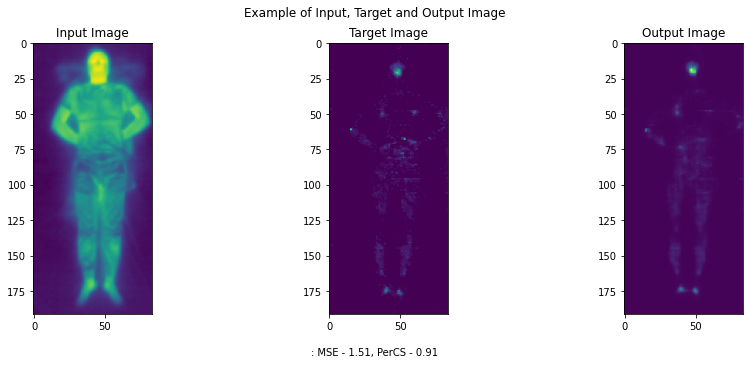

--------------------------------------------------
Evaluation for cover: cover1
Len dataset: 306
Val loader info: {'Number of samples': 306, 'Batch size': 1, 'Number of batches': 306}
Model Loaded
Evaluation completed
[MSELoss(), PerCS()]
[1.5759103298187256, 0.9039325510296712]
MSE - 1.58, PerCS - 0.90


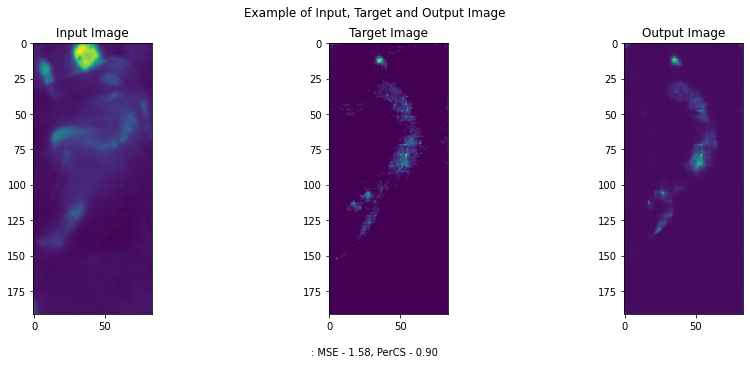

--------------------------------------------------
Evaluation for cover: cover2
Len dataset: 306
Val loader info: {'Number of samples': 306, 'Batch size': 1, 'Number of batches': 306}
Model Loaded
Evaluation completed
[MSELoss(), PerCS()]
[1.5193610191345215, 0.9020300828664795]
MSE - 1.52, PerCS - 0.90


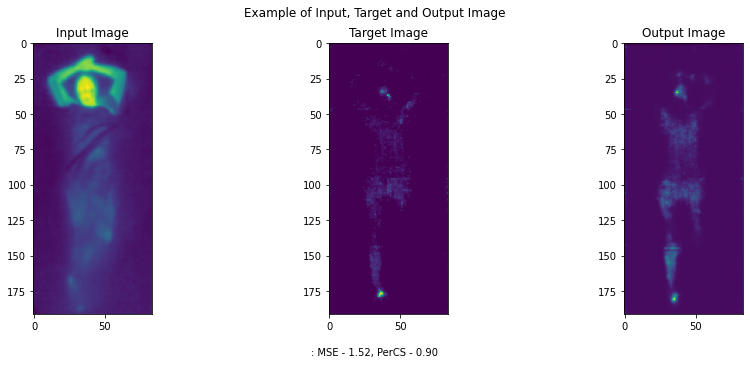

--------------------------------------------------


In [13]:
print("-" * 50)
print("EVALUATION FOR EACH COVER")
print("-" * 50)

covers = ['uncover','cover1','cover2']

for cover in covers:
    print('Evaluation for cover:',cover)
    filter_dic = filter_files(dic_paths,cover)
    # Create dataloader
    test_loader = create_dataloader(filter_dic,p_data,transform)
    # Do the evaluation
    epoch_metric = evaluation(USE_PHYSICAL_DATA,model,model_file,m,test_loader,True,False)
    print("-" * 50)



--------------------------------------------------
EVALUATION FOR EACH PATIENT
--------------------------------------------------
Evaluation for pacient: /00026/
Len dataset: 9
Val loader info: {'Number of samples': 9, 'Batch size': 1, 'Number of batches': 9}
Model Loaded
Evaluation completed
[MSELoss(), PerCS()]
[0.6905279755592346, 0.9055886243386245]
MSE - 0.69, PerCS - 0.91


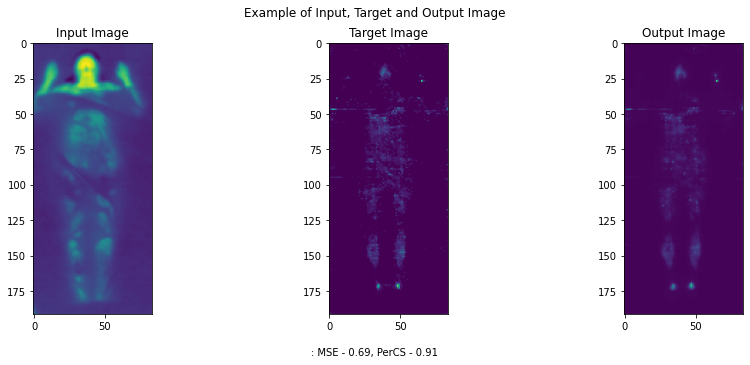

--------------------------------------------------
Evaluation for pacient: /00081/
Len dataset: 9
Val loader info: {'Number of samples': 9, 'Batch size': 1, 'Number of batches': 9}
Model Loaded
Evaluation completed
[MSELoss(), PerCS()]
[0.5541411638259888, 0.914193397266314]
MSE - 0.55, PerCS - 0.91


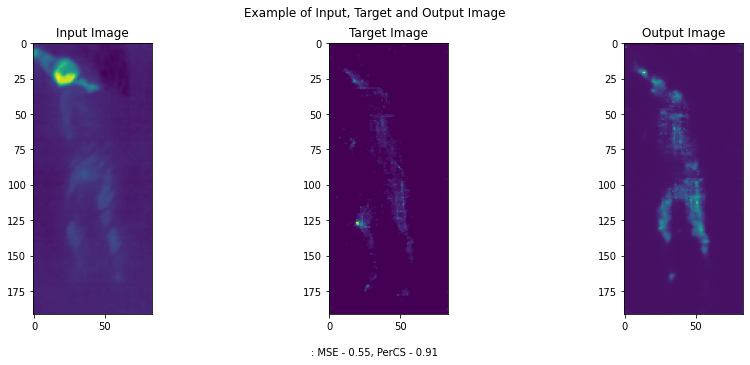

--------------------------------------------------
Evaluation for pacient: /00082/
Len dataset: 9
Val loader info: {'Number of samples': 9, 'Batch size': 1, 'Number of batches': 9}
Model Loaded
Evaluation completed
[MSELoss(), PerCS()]
[3.205350160598755, 0.9165357694003529]
MSE - 3.21, PerCS - 0.92


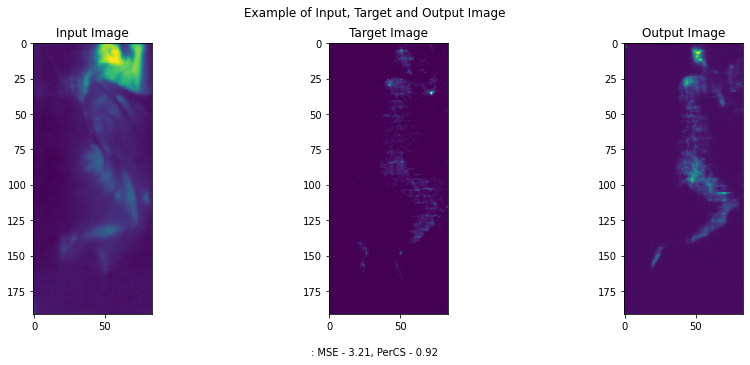

--------------------------------------------------
Evaluation for pacient: /00087/
Len dataset: 9
Val loader info: {'Number of samples': 9, 'Batch size': 1, 'Number of batches': 9}
Model Loaded
Evaluation completed
[MSELoss(), PerCS()]
[3.3926310539245605, 0.9174933862433863]
MSE - 3.39, PerCS - 0.92


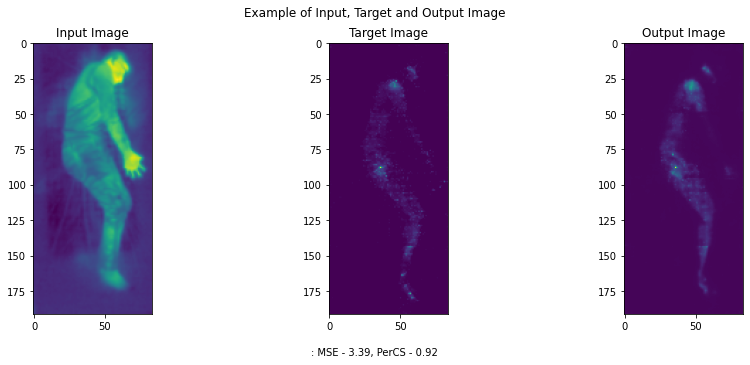

--------------------------------------------------
Evaluation for pacient: /00089/
Len dataset: 9
Val loader info: {'Number of samples': 9, 'Batch size': 1, 'Number of batches': 9}
Model Loaded
Evaluation completed
[MSELoss(), PerCS()]
[0.4858350157737732, 0.9005318562610231]
MSE - 0.49, PerCS - 0.90


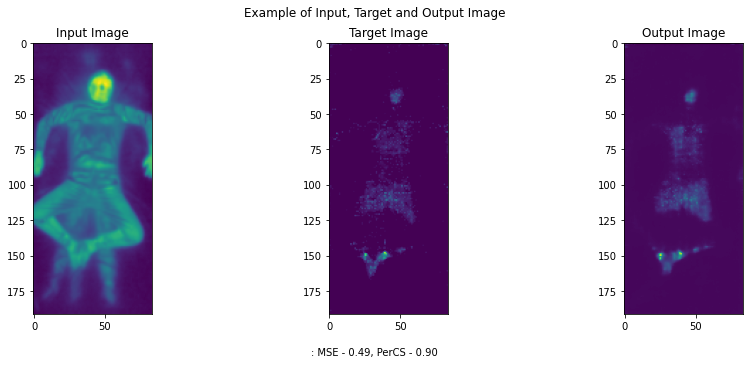

--------------------------------------------------
Evaluation for pacient: /00093/
Len dataset: 9
Val loader info: {'Number of samples': 9, 'Batch size': 1, 'Number of batches': 9}
Model Loaded
Evaluation completed
[MSELoss(), PerCS()]
[2.6244850158691406, 0.898520171957672]
MSE - 2.62, PerCS - 0.90


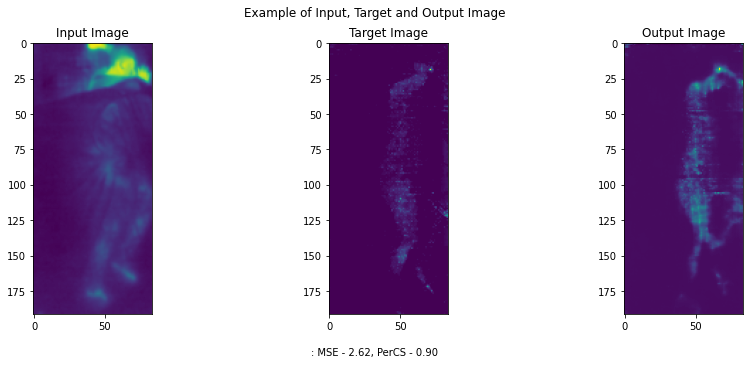

--------------------------------------------------


In [12]:
print("-" * 50)
print("EVALUATION FOR EACH PATIENT")
print("-" * 50)

pacients = [f'/{str(i).zfill(5)}/' for i in range(1, 103)]

results_mse = {}
results_pecs = {}


for pacient in pacients:
    if pacient in ['/00082/','/00087/','/00093/','/00089/','/00026/','/00081/']:
        print('Evaluation for pacient:',pacient)
        filter_dic = filter_files(dic_paths,pacient)
        # Create dataloader
        test_loader = create_dataloader(filter_dic,p_data,transform)
        # Do the evaluation
        epoch_metric = evaluation(USE_PHYSICAL_DATA,model,model_file,m,test_loader,True,False)
        results_mse[pacient]=epoch_metric[0]
        results_pecs[pacient]=epoch_metric[1]
        print("-" * 50)



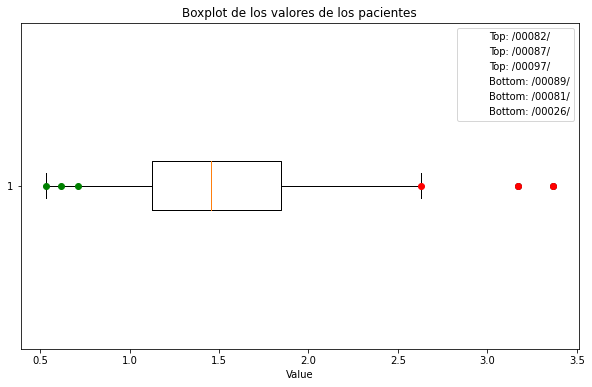

In [27]:
# Convertir el diccionario a un DataFrame de pandas
df = pd.DataFrame(list(results_mse.items()), columns=['ID', 'Value'])

# Crear el boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(df['Value'], vert=False)
plt.xlabel('Value')
plt.title('Boxplot de los valores de los pacientes')

# Identificar los top 3 y bottom 3
top_3 = df.nlargest(3, 'Value')
bottom_3 = df.nsmallest(3, 'Value')

for i in range(top_3.shape[0]):
    plt.plot(top_3.iloc[i]['Value'], 1, 'ro')

for i in range(bottom_3.shape[0]):
    plt.plot(bottom_3.iloc[i]['Value'], 1, 'go')
    
# Crear líneas invisibles para la leyenda
for index, row in top_3.iterrows():
    plt.plot([], [], ' ', label=f"Top: {row['ID']}")

for index, row in bottom_3.iterrows():
    plt.plot([], [], ' ', label=f"Bottom: {row['ID']}")

# Añadir la leyenda
plt.legend(loc='upper right')

# Mostrar el plot
plt.show()

# Mostrar el plot
plt.show()

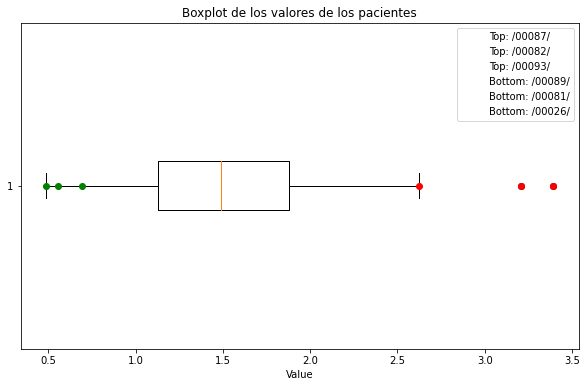

In [11]:
# Convertir el diccionario a un DataFrame de pandas
df = pd.DataFrame(list(results_mse.items()), columns=['ID', 'Value'])

# Crear el boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(df['Value'], vert=False)
plt.xlabel('Value')
plt.title('Boxplot de los valores de los pacientes')

# Identificar los top 3 y bottom 3
top_3 = df.nlargest(3, 'Value')
bottom_3 = df.nsmallest(3, 'Value')

for i in range(top_3.shape[0]):
    plt.plot(top_3.iloc[i]['Value'], 1, 'ro')

for i in range(bottom_3.shape[0]):
    plt.plot(bottom_3.iloc[i]['Value'], 1, 'go')
    
# Crear líneas invisibles para la leyenda
for index, row in top_3.iterrows():
    plt.plot([], [], ' ', label=f"Top: {row['ID']}")

for index, row in bottom_3.iterrows():
    plt.plot([], [], ' ', label=f"Bottom: {row['ID']}")

# Añadir la leyenda
plt.legend(loc='upper right')

# Mostrar el plot
plt.show()

# Mostrar el plot
plt.show()